In [1]:
# multivariate cnn example
from numpy import array
from numpy import hstack
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D


num_cols = ['Open','Close','High','Low','Adj Close','Volume']

def min_max_norm(column):
    return column.apply(lambda x: (x-column.min())/column.max())

def cat_labels(labels):
    labels = labels.map(lambda x: 0 if abs(x) < 0.5 else x)
    labels = labels.map(lambda x: 1 if x > 0 else x)
    labels = labels.map(lambda x: 2 if x < 0 else x)
    return labels

# split a multivariate sequence into samples
def split_sequences(sequences, labels,  n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
# find the end of this pattern
        end_ix = i + n_steps
# check if we are beyond the dataset
        if end_ix > len(sequences):
            break
# gather input and output parts of the pattern
        seq_x = sequences[i:end_ix]
        seq_y = labels[i]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

def shape_labels(labels):
    labels = np.nan_to_num(labels)
    labels = np.transpose(labels)
    b = np.zeros((labels.size, int(labels.max())+1))
    labels = labels.astype(np.int32)
    b[np.arange(labels.size), labels] = 1
    labels = b
    print(labels.shape)
    return labels

Using TensorFlow backend.


In [3]:
dow = pd.read_csv('Dow_technical_indicator_labels.csv')
dow.head()

,Unnamed: 0,Date,Open,High,Low,Close,Adj Close,Volume,volume_cmf,volume_em,...,cmf_low,keltner_indicator,bbands_indicator,ichimoku_label,macd_indicator,ease_label,stochastic_label,rsi_label,cmf_label,dow_labels
0,0,1985-01-29,1277.719971,1295.489990,1266.890015,1292.619995,1292.619995,13560000,0.799301,0.000000,...,-0.05,1,0.0,0,0,0,0,0,0,1.0
1,1,1985-01-30,1297.369995,1305.099976,1278.930054,1287.880005,1287.880005,16820000,0.181804,1684.243358,...,-0.05,1,0.0,0,0,0,0,0,0,0.0
2,2,1985-01-31,1283.239990,1293.400024,1272.640015,1286.770020,1286.770020,14070000,0.238612,-1327.193941,...,-0.05,1,0.0,0,0,-1,0,0,0,1.0
3,3,1985-02-01,1276.939941,1286.109985,1269.770020,1277.719971,1277.719971,10980000,0.186011,-755.986339,...,-0.05,0,0.0,0,0,0,0,0,0,1.0
4,4,1985-02-04,1272.079956,1294.939941,1268.989990,1290.079956,1290.079956,11630000,0.262218,898.087641,...,-0.05,1,0.0,0,0,1,1,1,0,-1.0


In [6]:
dow_labels

0       1.0
1       0.0
2       1.0
3       1.0
4      -1.0
       ... 
8734    0.0
8735    NaN
8736    NaN
8737    NaN
8738    NaN
Name: dow_labels, Length: 8739, dtype: float64

In [9]:
dow_labels = dow['dow_labels']
# dow_labels = pd.read_csv('../Dow_daily_labels.csv', header=None)

# snp = pd.read_csv('../S&P500_Data_Daily.csv')
# snp_labels = pd.read_csv('../SP_daily_labels.csv', header=None)

# nas = pd.read_csv('../NASDAQ_Data_Daily.csv')
# nas_labels = pd.read_csv('../NASDAQ_daily_labels.csv', header=None)


# dow = dow.drop([0,1,2,8738])
# nas = nas.drop([0,1,2,8738])
# snp = snp.drop([0,1,2,8738])

dow_labels = cat_labels(dow_labels)
# snp_labels = cat_labels(snp_labels[0])
# nas_labels = cat_labels(nas_labels[0])

dow_labels = shape_labels(dow_labels)
# snp_labels = shape_labels(snp_labels)
# nas_labels = shape_labels(nas_labels)

for col in num_cols:
    dow[col] = min_max_norm(dow[col])
#     snp[col] = min_max_norm(snp[col])
#     nas[col] = min_max_norm(nas[col])

(8735, 3)


In [10]:
len(dow)

8735

In [11]:
r1 = ['1989-03-01','1991-03-28']
r2 = ['1999-11-01','2001-11-30']
r3 = ['2007-06-01','2009-06-30']

def get_recession_test_train(df, labels):
    try:
        df = df.set_index('Date')
    except:
        pass
    
    train = pd.concat([df.loc[r1[0]:r1[1]],df.loc[r2[0]:r2[1]]])
    test = df.loc[r3[0]:r3[1]]
    
    idx1 = np.where(df.index==r1[0])[0][0]
    idx2 = np.where(df.index==r1[1])[0][0]+1
    
    idx3 = np.where(df.index==r2[0])[0][0]
    idx4 = np.where(df.index==r2[1])[0][0]+1
    
    idx5 = np.where(df.index==r3[0])[0][0]
    idx6 = np.where(df.index==r3[1])[0][0]+1
    
    train_labels = np.concatenate((labels[idx1:idx2],labels[idx3:idx4]),axis=0)
    test_labels = labels[idx5:idx6]
                                  
    print(len(train),train_labels.shape) 
    print(len(test),test_labels.shape)  
    return(train, test, train_labels, test_labels)

In [12]:
b1 = ['1991-04-01','1993-04-30']
b2 = ['2001-12-03','2003-12-31']
b3 = ['2009-07-01','2011-07-29']

def get_boom_test_train(df, labels):
    try:
        df = df.set_index('Date')
    except:
        pass
    train = pd.concat([df.loc[b1[0]:b1[1]],df.loc[b2[0]:b2[1]]])
    test = df.loc[b3[0]:b3[1]]
    
    idx1 = np.where(df.index==b1[0])[0][0]
    idx2 = np.where(df.index==b1[1])[0][0]+1
    
    idx3 = np.where(df.index==b2[0])[0][0]
    idx4 = np.where(df.index==b2[1])[0][0]+1
    
    idx5 = np.where(df.index==b3[0])[0][0]
    idx6 = np.where(df.index==b3[1])[0][0]+1
    
    train_labels = np.concatenate((labels[idx1:idx2],labels[idx3:idx4]),axis=0)
    test_labels = labels[idx5:idx6]
                                  
    print(len(train),train_labels.shape) 
    print(len(test),test_labels.shape) 
    return(train, test, train_labels, test_labels)

In [13]:
test_year_dates = ['2018-08-01','2019-08-30']
t1year = ['2017-07-03','2018-07-30']
t5year = ['2013-07-01','2018-07-30']

# train_type should be ['1_year','5_year','all']
def get_recent_test_train(df, train_type, labels):
    try:
        df = df.set_index('Date')
    except:
        pass
    test = df.loc[test_year_dates[0]:test_year_dates[1]]

    idx3 = np.where(df.index==test_year_dates[0])[0][0]
    idx4 = np.where(df.index==test_year_dates[1])[0][0]+1

    if train_type == '1_year':
        train = df.loc[t1year[0]:t1year[1]]
        idx1 = np.where(df.index==t1year[0])[0][0]
        idx2 = np.where(df.index==t1year[1])[0][0]+1
    elif train_type == '5_year':
        idx1 = np.where(df.index==t5year[0])[0][0]
        idx2 = np.where(df.index==t5year[1])[0][0]+1
        train = df.loc[t5year[0]:t5year[1]]
    elif train_type == 'all':
        train = df.loc[:t1year[1]]
        idx1 = 0
        idx2 = np.where(df.index==t5year[1])[0][0]+1
    else:
        print("train_type must be one of the following:")
        print('1_year, ','5_year, ','or all')
        return(0,0)
    
    train_labels = labels[idx1:idx2]
    test_labels = labels[idx3:idx4]
    
                                      
    print(len(train),train_labels.shape) 
    print(len(test),test_labels.shape) 
    return(train, test, train_labels, test_labels)

In [14]:
train, test, train_labels, test_labels = get_recent_test_train(dow, '5_year', dow_labels)

1280 (1280, 3)
273 (273, 3)


In [15]:
train.head()

,Unnamed: 0,Open,High,Low,Close,Adj Close,Volume,volume_cmf,volume_em,volume_sma_em,...,cmf_low,keltner_indicator,bbands_indicator,ichimoku_label,macd_indicator,ease_label,stochastic_label,rsi_label,cmf_label,dow_labels
Date,,,,,,,,,,,,,,,,,,,,,
2013-07-01,7165,0.499472,0.504844,0.501062,0.501949,0.501949,0.053880,-0.052608,5371.709134,-3238.964969,...,-0.05,1,0.0,0,0,1,1,0,-1,1.0
2013-07-02,7166,0.501787,0.503601,0.499556,0.500394,0.500394,0.052072,-0.053798,-5758.564054,-2643.313479,...,-0.05,1,0.0,0,0,-1,-1,0,0,1.0
2013-07-03,7167,0.499915,0.502750,0.499132,0.502439,0.502439,0.026689,0.000280,-4776.376795,-2416.630091,...,-0.05,1,0.0,0,0,0,1,0,0,1.0
2013-07-05,7168,0.502536,0.506824,0.503246,0.507830,0.507830,0.042007,-0.017030,19687.694126,-1519.216216,...,-0.05,1,0.0,0,-1,1,0,0,0,1.0
2013-07-08,7169,0.507717,0.511394,0.509328,0.511077,0.511077,0.061297,-0.043789,13356.710047,-986.174364,...,-0.05,1,0.0,0,0,0,0,0,0,0.0


In [16]:
test.head()

,Unnamed: 0,Open,High,Low,Close,Adj Close,Volume,volume_cmf,volume_em,volume_sma_em,...,cmf_low,keltner_indicator,bbands_indicator,ichimoku_label,macd_indicator,ease_label,stochastic_label,rsi_label,cmf_label,dow_labels
Date,,,,,,,,,,,,,,,,,,,,,
2018-08-01,8446,0.885006,0.884626,0.880876,0.880574,0.880574,0.143029,0.220305,-2301.182697,2196.557558,...,-0.05,1,0.0,0,0,-1,-1,0,0,-1.0
2018-08-02,8447,0.877508,0.879943,0.875078,0.880294,0.880294,0.139296,0.221386,-11195.062303,989.339494,...,-0.05,1,0.0,0,0,0,0,0,0,-1.0
2018-08-03,8448,0.881306,0.883863,0.882593,0.885280,0.885280,0.107946,0.242589,9331.030715,1485.677261,...,-0.05,1,0.0,0,0,1,1,0,0,-1.0
2018-08-06,8449,0.884122,0.886496,0.884652,0.886728,0.886728,0.107933,0.227658,4259.197664,1570.169224,...,-0.05,1,0.0,0,0,0,0,0,0,-1.0
2018-08-07,8450,0.888296,0.892069,0.890891,0.891360,0.891360,0.108353,0.204392,9495.556246,1971.903593,...,-0.05,1,0.0,0,0,0,0,0,0,1.0


In [18]:
test.columns

Index(['Unnamed: 0', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'volume_cmf', 'volume_em', 'volume_sma_em', 'volatility_bbh',
       'volatility_bbl', 'volatility_bbm', 'volatility_bbhi',
       'volatility_bbli', 'volatility_kcc', 'volatility_kch', 'volatility_kcl',
       'volatility_kchi', 'volatility_kcli', 'trend_macd', 'trend_macd_signal',
       'trend_macd_diff', 'trend_ichimoku_a', 'trend_ichimoku_b',
       'momentum_rsi', 'momentum_stoch', 'momentum_stoch_signal', 'Zero',
       'rsi_high', 'rsi_low', 'cmf_high', 'cmf_low', 'keltner_indicator',
       'bbands_indicator', 'ichimoku_label', 'macd_indicator', 'ease_label',
       'stochastic_label', 'rsi_label', 'cmf_label', 'dow_labels'],
      dtype='object')

In [19]:
num_cols = ['Open', 'Close', 'High', 'Low', 'Adj Close', 'Volume','keltner_indicator',
       'bbands_indicator', 'ichimoku_label', 'macd_indicator', 'ease_label',
       'stochastic_label', 'rsi_label', 'cmf_label']

In [21]:
# https://machinelearningmastery.com/how-to-develop-convolutional-neural-network-models-for-time-series-forecasting/
n_steps = 60
# convert into input/output
data = train[num_cols].to_numpy()
labels = train_labels
X, y = split_sequences(data, labels, n_steps)
# the dataset knows the number of features, e.g. 2
n_features = X.shape[2]
# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps, n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# fit model
model.fit(X, y, epochs=150, batch_size = int(X.shape[0]*0.05))


Epoch 1/150
1221/1221 [==============================] - 0s 251us/step - loss: 0.9291 - accuracy: 0.6380
Epoch 2/150
1221/1221 [==============================] - 0s 130us/step - loss: 0.7172 - accuracy: 0.7166
Epoch 3/150
1221/1221 [==============================] - 0s 163us/step - loss: 0.6828 - accuracy: 0.7289
Epoch 4/150
1221/1221 [==============================] - 0s 131us/step - loss: 0.6267 - accuracy: 0.7412
Epoch 5/150
1221/1221 [==============================] - 0s 145us/step - loss: 0.5918 - accuracy: 0.7535
Epoch 6/150
1221/1221 [==============================] - 0s 127us/step - loss: 0.5462 - accuracy: 0.7682
Epoch 7/150
1221/1221 [==============================] - 0s 163us/step - loss: 0.5344 - accuracy: 0.7723
Epoch 8/150
1221/1221 [==============================] - 0s 148us/step - loss: 0.5132 - accuracy: 0.7797
Epoch 9/150
1221/1221 [==============================] - 0s 134us/step - loss: 0.5450 - accuracy: 0.7666
Epoch 10/150
1221/1221 [==============================]

In [22]:
X, y = split_sequences(test[num_cols].to_numpy(), test_labels, 60)

model.evaluate(X, y)

214/214 [==============================] - 0s 218us/step


[1.8512356582089005, 0.7757009267807007]

In [167]:
model.metrics_names

['loss', 'accuracy']

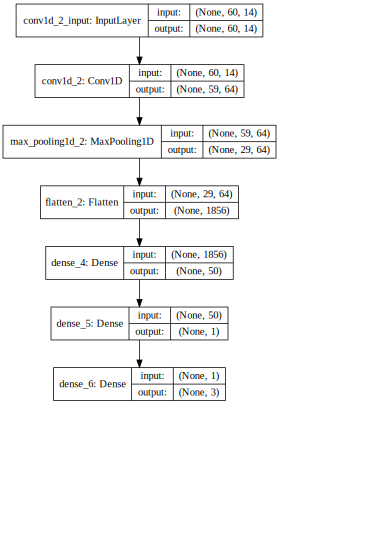

In [36]:
import keras
import pydot as pyd
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

keras.utils.vis_utils.pydot = pyd

#Visualize Model

def visualize_model(model):
  return SVG(model_to_dot(model, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))
#create your model
#then call the function on your model
visualize_model(model)

In [35]:
import keras
import pydotplus
from keras.utils.vis_utils import model_to_dot
keras.utils.vis_utils.pydot = pydot
plot_model(autoencoder, to_file='model.png', show_shapes=True, show_layer_names=True)

NameError: name 'pydot' is not defined

In [32]:
from keras.utils.vis_utils import plot_model
# import pydotplus
# keras.utils.vis_utils.pydot = pydot
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

ImportError: Failed to import `pydot`. Please install `pydot`. For example with `pip install pydot`.

In [37]:
data

array([[ 0.49947176,  0.50194925,  0.50484441, ...,  1.        ,
         0.        , -1.        ],
       [ 0.50178717,  0.50039402,  0.50360127, ..., -1.        ,
         0.        ,  0.        ],
       [ 0.49991507,  0.5024394 ,  0.50275015, ...,  1.        ,
         0.        ,  0.        ],
       ...,
       [ 0.88525912,  0.88763764,  0.88821909, ..., -1.        ,
         0.        ,  0.        ],
       [ 0.88715823,  0.88485942,  0.88796289, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.88419093,  0.87958767,  0.88504083, ...,  0.        ,
         0.        ,  0.        ]])